# Latency of image arrival at USDF after shutter close

In [1]:
# This cell is only for setting parameter defaults
day = "20241201"
instrument = 'LSSTCam'

In [2]:
from lsst.daf.butler import Butler
from lsst.daf.butler.registry import Registry
import sqlalchemy
from astropy import time
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time
import boto3.session
from datetime import datetime, timezone


repo = 'embargo_new'
dt = 'raw'
# raw all collection contains all images 
collections = [f'{instrument}/raw/all']
butler = Butler(repo, collections=collections, instrument=instrument)
where = f"day_obs={day}"

endpoint_url = "https://sdfembs3.sdf.slac.stanford.edu/"
boto_profile = "embargo"

day_obs = int(day)
cap = 300


# Data transferred and ingested in butler and access to data



In [3]:
with butler.query() as q:
    q = q.join_dataset_search(dt,collections)
    q = q.where(day_obs=day_obs)
    rows = q.general(["exposure"], "raw.ingest_date", "obs_id", "detector.full_name", find_first=False)
    # ordering by exposure.id ('.id' is optional) and ingest_date (or 'raw.ingest_date')
    result = list(rows.order_by("exposure", "ingest_date"))

print (f"Got ingest times for {len(result)} {instrument} images on day_obs={day}")


Got ingest times for 275989 LSSTCam images on day_obs=20241201


### latency ..
"Measure the delays between completion of readout for each image and the ingestion time recorded in the Butler Registry."
Get the shuter close time for each exposre 
the ID in the dimension record is the exposure ID (dimensionRecord.id)
thed timespan.end is the sutter close time 


In [4]:
shutterTimes = butler.registry.queryDimensionRecords('exposure', where=where, instrument=instrument)
nt = shutterTimes.count()

print (f"Got Metadata (DimensionRecords) for {nt} {instrument} {instrument} exposures")


Got Metadata (DimensionRecords) for 1401 LSSTCam LSSTCam exposures


get shutter times and calculate the time to ingest

In [5]:
exptimes = {}
for exp in shutterTimes:
    exptimes[exp.id] = exp.timespan.end

ingest_times = [res["raw.ingest_date"] for res in result]
exposure_times = [exptimes[res["exposure"]] for res in result]
seconds = []
if len(ingest_times) > 0:
    seconds = (Time(ingest_times) - Time(exposure_times)).to('second')  # per image
    


Arrival time to S3 at SLAC

In [6]:
client = boto3.session.Session(profile_name=boto_profile).client("s3", endpoint_url=endpoint_url)

def get_s3_time(count, ingestt):
    # coutn is the index inthe result set 
    exposure_time = exposure_times[count]
    #exposure_time = Time(exposure_time, scale = 'utc')
    r = result[count]
    inst = r['instrument']
    obs_id = r['exposure.obs_id']
    detector = r['detector.full_name']
    # get instrument, day_obs, obs_id, detector (full name), e.g. from `q.general()` Butler query
    key = f"{inst}/{day}/{obs_id}/{obs_id}_{detector}.fits"
    response = client.head_object(Bucket="rubin-summit", Key=key)
    arrival_time = Time(response["LastModified"], format="datetime")
    s3arrt = (arrival_time - exposure_time).to('second').value
    if (False and ingestt < s3arrt):
        deltai = (ingest_times[count] - arrival_time).to('second')
        print(f" ingest:{ingestt}, s3:{s3arrt}")
        print(f"exposure time : {exposure_time}, {exptimes[r['exposure']]}")
        print(f"s3time : {arrival_time}  for {key}")
        print(f"ingest time : {ingest_times[count]}, {r['raw.ingest_date']}.  deltai:{deltai}")

    return s3arrt


def capf(v,c):
    if v >c:
        return c
    else:
        return v

vcap = np.vectorize(capf)
    

Use the exposure times to work out the time for each imagetransfer  and the max and min for each exposure

In [7]:
#cumulative ingest times for Zjelko
tot = len(seconds)

sord=[]
if  tot > 0:
    sord = np.sort(seconds)
    rank = np.arange(0, tot, 1)
    cumulative = (rank / tot)  # per image

In [8]:
min = 100.0
max = 0.0
amin = 100
amax = 0
prev = None
prevt = 0
startexp = 0
nt = len(exptimes)
ecount = 0
expt = np.array([t.to_value('mjd') for t in exptimes.values()])  # per exposure 
expmins  = np.empty(shape = [nt]) # the fastest tranfer
expmaxs  = np.empty(shape = [nt]) # slowes transfer
arrmins  = np.empty(shape = [nt]) # the fastest tranfer - but s3 arrival time
arrmaxs  = np.empty(shape = [nt]) # slowes transfer - but s3 arrival time

if (len(seconds) > 0):
    for count, ts in enumerate(seconds):
        t = ts.value
        if exposure_times[count] != prev : # boundary of exposure - individial times should be ordered
            expmins[ecount] = t
            arrmins[ecount] = get_s3_time(count, t)
            if (arrmins[ecount]) < amin:
                amin = arrmins[ecount]
            if ecount > 0:
                expmaxs[ecount] = prevt
                arrmaxs[ecount] = get_s3_time(count - 1, prevt)
                if (arrmaxs[ecount]) > amax:
                    amax = arrmaxs[ecount]
            ecount = ecount + 1
            if t < min:
               min = t
            if prevt > max:
               max = prevt     
            prev = exposure_times[count]
        prevt = t
    print (f"Counted {ecount +1} exposures.")
    print (f"The min transfer time was {amin} max transfer time was {amax} seconds.")
    print (f"The min ingest time was {min} max ingest time was {max} seconds over {len(seconds)} times.")
    print (f"Time between shutter close and ingest median:{np.median(seconds)}, mean:{np.mean(seconds)}, std:{np.std(seconds)}, var:{np.var(seconds)}")
else:
    print("No data")

Counted 1402 exposures.
The min transfer time was 2.936000000009642 max transfer time was 22.00199999999306 seconds.
The min ingest time was 3.7524259999926812 max ingest time was 263.95399700000473 seconds over 275989 times.
Time between shutter close and ingest median:9.863241999992312 s, mean:15.919773795176448 s, std:30.46297267273856 s, var:927.9927040600163 s2


In [9]:
#cumulative transfertimes

s3times = np.concatenate((arrmins,arrmaxs), axis=0)
tot = len(s3times)
s3ord = []
if  tot > 0:
    s3ord = np.sort(s3times)
    rank = np.arange(0, tot, 1)
    s3cumulative = (rank / tot)  # per image

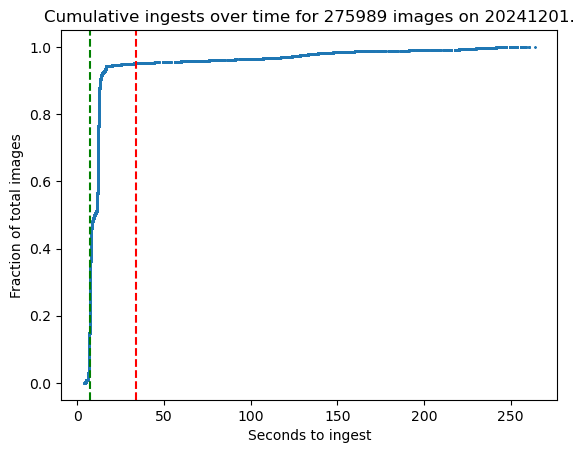

In [10]:
if len(sord) > 0:
    plt.scatter(sord, cumulative, marker="*", s=0.5)

plt.xlabel(f"Seconds to ingest")
plt.ylabel("Fraction of total images")

plt.title(f"Cumulative ingests over time for {len(sord)} images on {day}.")
plt.axvline(x = 7, color = 'g', linestyle = '--', ymin=0, ymax=1) 
plt.axvline(x = 34, color = 'r', linestyle = '--', ymin=0, ymax=1) 


plt.show()

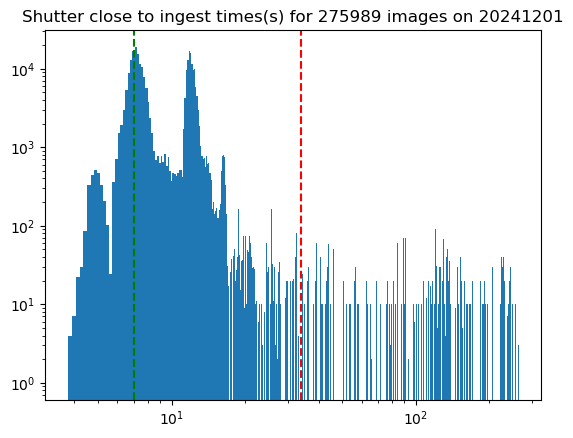

In [11]:
plt.hist(seconds,bins='auto')
plt.yscale('log')
plt.xscale('log')
plt.title(f"Shutter close to ingest times(s) for {len(seconds)} images on {day}")
plt.axvline(x = 7, color = 'g', linestyle = '--', ymin=0, ymax=1) 
plt.axvline(x = 34, color = 'r', linestyle = '--', ymin=0, ymax=1) 

plt.show()

Green line is 7 seconds, Red line 34 seconds 

## The max and min transfer time for each exposure
For each exposure the fastes (blue) and slowest (orange) file transfer is ploted.
Camera may resend images later which will lead to an artifically large time to send since we look at shutter close time (especially relative to ingest time). 

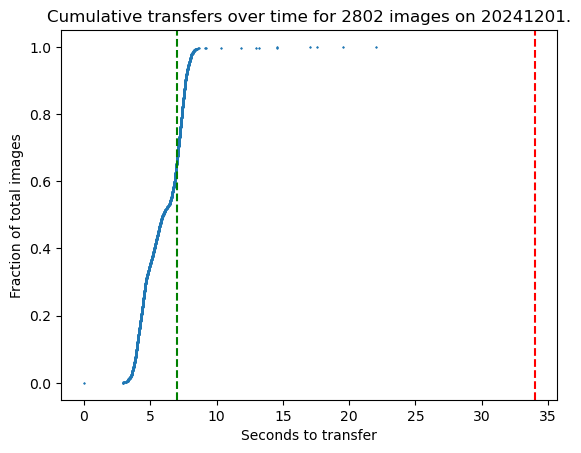

In [12]:
if len(s3ord) > 0:
    plt.scatter(s3ord, s3cumulative, marker="*", s=0.5)

plt.xlabel(f"Seconds to transfer")
plt.ylabel("Fraction of total images")

plt.title(f"Cumulative transfers over time for {len(s3ord)} images on {day}.")
plt.axvline(x = 7, color = 'g', linestyle = '--', ymin=0, ymax=1) 
plt.axvline(x = 34, color = 'r', linestyle = '--', ymin=0, ymax=1) 


plt.show()

In [13]:
# For the axis 
#times = [t.strftime('%H:%M') for t in exptimes.values()]  # per exposure 
times = [t.to_value('datetime') for t in exptimes.values()]  # per exposure 


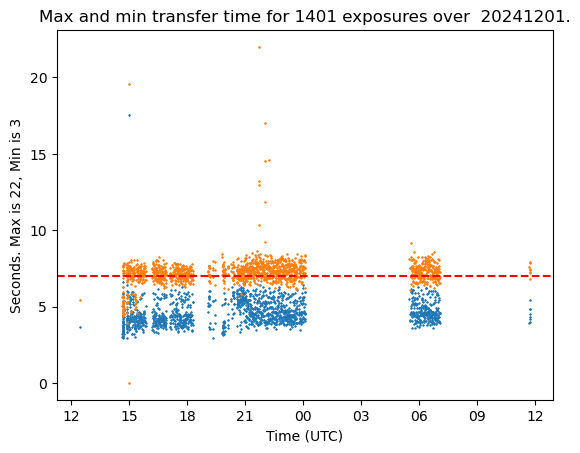

In [14]:
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%H')
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(myFmt)

if amax >= cap:
    plt.ylim([0,cap+2])
    arm = vcap(arrmins,cap)
    arx = vcap(arrmaxs,cap)
else:
    arm = arrmins
    arx = arrmaxs

plt.scatter(times, arm, marker="*", s=0.6)
plt.scatter(times, arx, marker="*", s=0.6)
plt.xlabel(f"Time (UTC)")

plt.title(f"Max and min transfer time for {len(expt)} exposures over  {day}.")
plt.axhline(y = 7, color = 'r', linestyle = '--') 
if amax >= cap:
    plt.axhline(y = cap-1, color = 'b', linestyle = ':') 
    plt.ylabel(f"Seconds (capped at {cap}. Max is {amax:.0f}, Min is {amin:.0f}")
else:
    plt.ylabel(f"Seconds. Max is {amax:.0f}, Min is {amin:.0f}")

plt.show()

Red line 7s, Blue line is the CAP points on the line are off plot 

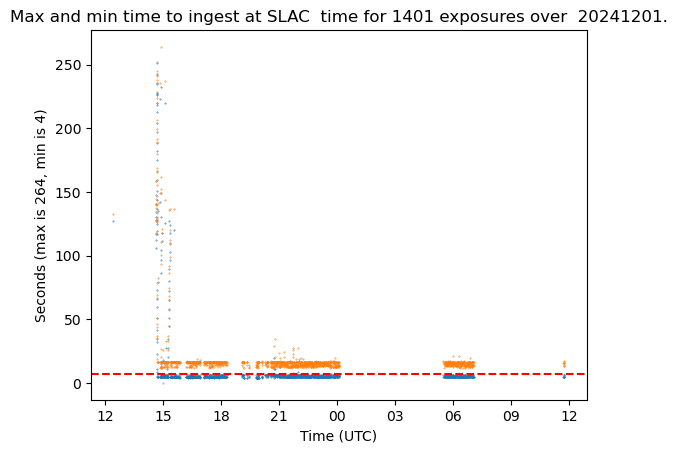

In [15]:
myFmt = mdates.DateFormatter('%H')
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(myFmt)
plt.title(f"Max and min time to ingest at SLAC  time for {len(expt)} exposures over  {day}.")

if (max > cap):
    plt.ylim([0,cap+2])
    exm = vcap(expmins,cap)
    exx = vcap(expmaxs,cap)
    plt.axhline(y = cap-1, color = 'b', linestyle = ':') 
    plt.ylabel(f"Seconds (capped at {cap} max is {max:.0f}, min is {min:.0f})")

else:
    exm = expmins
    exx = expmaxs 
    plt.ylabel(f"Seconds (max is {max:.0f}, min is {min:.0f})")

plt.scatter(times, exm, marker=".", s=0.5)
plt.scatter(times, exx, marker=".", s=0.5)

plt.xlabel(f"Time (UTC)")

plt.axhline(y = 7, color = 'r', linestyle = '--') 

plt.show()

## Time between exposures 

In [16]:
expt.sort()
expts = expt[1:]

betweentimes = (Time(expts, format='mjd') - Time(expt[0:-1], format='mjd')).to('second')  # per image

#print(f"Got {len(betweentimes)} betweentimes and {len(expts)} exposures.")
#print (f"Time between exposures mean:{np.mean(betweentimes)}, std:{np.std(betweentimes)}, var:{np.var(betweentimes)} seconds")


In [ ]:
myFmt = mdates.DateFormatter('%H')
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(myFmt)

plt.scatter(times[1:], betweentimes, marker=".", s=0.7)
plt.axhline(y = 34, color = 'r', linestyle = '--') 
plt.yscale('log')
plt.xlabel(f"Time (UTC) ")
plt.ylabel("Seconds (log scale)")
plt.title(f"Time between  {len(betweentimes) + 1}  exposures  on {day}")
plt.show()

Red line is 34 sec nominal time between exposures

# See Also
The butler postgress database at SLAC for the same day.

In [18]:
## See also  from=1729393200000&to=1729479599000
fromt = datetime.now(timezone.utc).replace(hour=0,minute=0,second=0)
tot = datetime.now(timezone.utc).replace(hour=23,minute=59,second=59)
if  len(exposure_times) > 0:
    fromt = exposure_times[0].to_value('datetime')
    tot = exposure_times[-1].to_value('datetime')
fromt = fromt.timestamp() * 1000
tot = tot.timestamp() * 1000
print(f"https://grafana.slac.stanford.edu/d/z7FCA4Nnk/cloud-native-postgresql-cnpg?orgId=1&refresh=30s&var-DataSource=940RXge4k&var-vcluster=vcluster--usdf-butler&var-cluster=usdf-butler-embargo16&var-instances=All&var-namespace=embargo16-prod&var-resolution=5m&from={fromt}&to={tot}")

https://grafana.slac.stanford.edu/d/z7FCA4Nnk/cloud-native-postgresql-cnpg?orgId=1&refresh=30s&var-DataSource=940RXge4k&var-vcluster=vcluster--usdf-butler&var-cluster=usdf-butler-embargo16&var-instances=All&var-namespace=embargo16-prod&var-resolution=5m&from=1733055949431.0&to=1733139943036.0
